In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import os
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier

# Итотовая работа по ML
- Подробности на странице на платформе
- Данные в этой работе используются такие же, как и в соревновании по ML (ДЗ 1), за исключением того, что для test датасета мы знаем метку класса "1" или "0". Обновленные данные доступны в соревновании на kaggle (файл называется test_full.csv)

In [3]:
path_data = ''

# не меняйте название переменных train и test - в которых лежат датасеты train.csv и test_full.csv соответсвенно
# эти файлы будут участвовать в тестировании работы

train = pd.read_csv(path_data + 'files_competition/train.csv')

# test датасет запрещается видоизменять - применять к нему какую либо логику трансформации
# можно видоизменять входные данные внутри функции def get_score(dict_input) (смотри ниже)

test = pd.read_csv(path_data + 'test_full.csv')

## Место для вашего кода ↓↓↓

## Обучение модели / написание вспомогательно кода ↓↓↓

In [4]:
def data_prepare(data):
    data_clean = data.copy()
    data_clean['использование_prepared'] = data['использование'].apply(lambda x: 1 if x == '>24LY' else 0)
    return data_clean

In [5]:
clean_data = data_prepare(train)

In [6]:
feature_cols = [
    'сумма',
    'частота_пополнения',
    'доход',
    'сегмент_arpu',
    'частота',
    'объем_данных',
    'on_net',
    'продукт_1',
    'продукт_2',
    'зона_1',
    'зона_2',
    'секретный_скор',
    'pack_freq',
    'использование_prepared',
]

target_col = 'binary_target'

In [7]:
params = {
    'booster': 'dart',
    'n_jobs': 1,
    'lambda': 5.505947819297863e-08,
    'alpha': 0.05516382844236534,
    'subsample': 0.3007234025925322,
    'colsample_bytree': 0.5406218842645367,
    'verbosity': -1
}
model_lgbm = LGBMClassifier(**params)


In [8]:
X = clean_data[feature_cols]
y = clean_data[target_col]

In [9]:
lgbm_classifier = model_lgbm.fit(X, y)

In [10]:
def find_optimal_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)  # Генерируем 100 равномерно распределенных порогов от 0 до 1
    best_threshold = None
    best_f1 = -1

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)  # Преобразуем вероятности в бинарные предсказания по порогу
        f1 = f1_score(y_true, y_pred)  # Вычисляем F1-меру для текущего порога

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

In [11]:
optimal_threshold_lgbm, max_f1_lgbm = find_optimal_threshold(y, lgbm_classifier.predict_proba(X)[:, 1])
(optimal_threshold_lgbm, max_f1_lgbm)

(0.32323232323232326, 0.6532215073529412)

## код логики production функции ↓↓↓
__Ограничение на число CPU в модели внутри функции def get_score - 1 ядро, это означает что нужно ставить следующие параметры (Модель должна на одном CPU)__
Если вы обучались на нескольких ядрах (или GPU) - поменяйте параметры в уже обученной модели, чтобы в production она использовала только одно ядро

- это нужно явно показать в коде
- для уже обученных моделей:
- для catboost - model.predict(thread_count=1)
- для lightgbm - model.set_params(n_jobs=1) и затем model.get_params().get('n_jobs')
- для xgboost - model.set_params(n_jobs=1) и затем model.get_params()['n_jobs']
- для других классификаторов смотрите документацию



In [12]:
def preprocess(data):
    prepared_data = []
    data['использование_prepared'] = 1 if data['использование'] == '>24LY' else 0
    for f in feature_cols:
        prepared_data.append(data[f])
    return prepared_data

In [13]:
# Это шаблон функции, которая будет тестироваться далее
# не меняйте формат input и output, а так же название функции
# в этой функции нужно сделать так, чтобы ваша модель использовала только 1 CPU при скоринге

def get_score(dict_input):
    series = preprocess(dict_input)
    pred = lgbm_classifier.predict_proba([series])[0][1]
    binary_prediction = int(pred >= optimal_threshold_lgbm)

    # вот это нельзя менять, иначе сломаются проверки
    return {
        "client_id": dict_input['client_id'],
        "prediction": binary_prediction,
    }

In [14]:
%load_ext line_profiler

In [15]:
row_input = {
    'client_id': 1010348,
    'регион': 'Нептун',
    'использование': '>24LY',
    'сумма': 31.69021931132696,
    'частота_пополнения': 16.0,
    'доход': 42653.164535362455,
    'сегмент_arpu': 441.45,
    'частота': 4.242640687119285,
    'объем_данных': 32.01562118716424,
    'on_net': np.nan,
    'продукт_1': 12.0,
    'продукт_2': np.nan,
    'зона_1': np.nan,
    'зона_2': np.nan,
    'mrg_': False,
    'секретный_скор': 0.6065573770491803,
    'pack': 'трафик: 100 (условие) 40mb,_сутки',
    'pack_freq': 3.0,
    'binary_target': 0
}

%lprun -f get_score get_score(row_input)

Timer unit: 1e-07 s

Total time: 0.0033879 s
File: C:\Users\derol\AppData\Local\Temp\ipykernel_12904\164188587.py
Function: get_score at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def get_score(dict_input):
     6         1        310.0    310.0      0.9      series = preprocess(dict_input)
     7         1      33471.0  33471.0     98.8      pred = lgbm_classifier.predict_proba([series])[0][1]
     8         1         71.0     71.0      0.2      binary_prediction = int(pred >= optimal_threshold_lgbm)
     9                                           
    10                                               # вот это нельзя менять, иначе сломаются проверки
    11         1         13.0     13.0      0.0      return {
    12         1         11.0     11.0      0.0          "client_id": dict_input['client_id'],
    13         1          3.0      3.0      0.0          "prediction": binary_prediction,
    14          

In [16]:
# подсказка

# следите за своей предобработкой
# основное время работы функции должна занимать модель
# можно использовать специальное расширение для понимания - сколько выполняется по времени каждая часть кода
# row_input = ...
# pip install line_profiler
# from line_profiler import profile
# %load_ext line_profiler
# %lprun -f get_score get_score(row_input)

______
## Тут нужно написать код для пятого пункта дз ↓↓↓

*проверка качества предсказания модели (без знания о целевой переменной, только на основе входных данных и выходного предсказания)*

In [17]:
# используйте этот код для расчета качества вашей модели
# процесс должен быть итеративным - поэтмоу используется цикл
# не забудте сделать понятную визуализацию


for row in tqdm(test.itertuples(index=False), total=len(test)):
    dict_input_ = {
        "client_id": row.client_id,
        "регион": row.регион,
        "использование": row.использование,
        "сумма": row.сумма,
        "частота_пополнения": row.частота_пополнения,
        "доход": row.доход,
        "сегмент_arpu": row.сегмент_arpu,
        "частота": row.частота,
        "объем_данных": row.объем_данных,
        "on_net": row.on_net,
        "продукт_1": row.продукт_1,
        "продукт_2": row.продукт_2,
        "зона_1": row.зона_1,
        "зона_2": row.зона_2,
        "mrg_": row.mrg_,
        "секретный_скор": row.секретный_скор,
        "pack": row.pack,
        "pack_freq": row.pack_freq,
    }
    score_result = get_score(dict_input_)




100%|██████████| 497586/497586 [02:43<00:00, 3037.29it/s]


## Место для вашего кода ↑↑↑
_______

## Автоматические проверки работы ↓↓↓
### Этот код менять нельзя, иначе проверки в ноутбуке могут сломаться

## тест 1: проверка input модели (1)

In [18]:
row_input = {
    'client_id': 1010348,
    'регион': 'Нептун',
    'использование': '>24LY',
    'сумма': 31.69021931132696,
    'частота_пополнения': 16.0,
    'доход': 42653.164535362455,
    'сегмент_arpu': 441.45,
    'частота': 4.242640687119285,
    'объем_данных': 32.01562118716424,
    'on_net': np.nan,
    'продукт_1': 12.0,
    'продукт_2': np.nan,
    'зона_1': np.nan,
    'зона_2': np.nan,
    'mrg_': False,
    'секретный_скор': 0.6065573770491803,
    'pack': 'трафик: 100 (условие) 40mb,_сутки',
    'pack_freq': 3.0,
    'binary_target': 0
}

In [19]:
# если завершилось без ошибок - тест пройден
get_score(row_input)

{'client_id': 1010348, 'prediction': 0}

## тест 2: проверка input модели (2)

In [20]:
row_input = {
    'client_id': -999,
    'регион': 'Калифорния',
    'использование': '<2года',
    'сумма': -999,
    'частота_пополнения': -16.0,
    'доход': -42653.164535362455,
    'сегмент_arpu': -441.45,
    'частота': 0.1,
    'объем_данных': -1,
    'on_net': np.nan,
    'продукт_1': -12.0,
    'продукт_2': np.nan,
    'зона_1': np.nan,
    'зона_2': np.nan,
    'mrg_': True,
    'секретный_скор': -0.6065573770491803,
    'pack': 'трафик Тройное условие 123',
    'pack_freq': -3.0,
    'binary_target': -0.1
}

In [21]:
# если завершилось без ошибок - тест пройден
get_score(row_input)

{'client_id': -999, 'prediction': 1}

## тест 3: проверка output модели

In [22]:
get_score_result = get_score(row_input)

In [23]:
# если завершилось без ошибок - тест пройден
assert get_score_result['prediction'] in [0, 1]

In [24]:
# если завершилось без ошибок - тест пройден
assert not bool(set(get_score_result.keys()) - set(['client_id', 'prediction']))

## тест 4: мониторинг времени (1)
- зеленый цвет названия графика означает - что тест пройден
- красный цвет названия графика означает - что тест не пройден

In [25]:
%%time

# тут ничего менять не нужно
times = []
preds = []

for row in tqdm(test.itertuples(index=False), total=len(test)):

    dict_input_ = {
        "client_id": row.client_id,
        "регион": row.регион,
        "использование": row.использование,
        "сумма": row.сумма,
        "частота_пополнения": row.частота_пополнения,
        "доход": row.доход,
        "сегмент_arpu": row.сегмент_arpu,
        "частота": row.частота,
        "объем_данных": row.объем_данных,
        "on_net": row.on_net,
        "продукт_1": row.продукт_1,
        "продукт_2": row.продукт_2,
        "зона_1": row.зона_1,
        "зона_2": row.зона_2,
        "mrg_": row.mrg_,
        "секретный_скор": row.секретный_скор,
        "pack": row.pack,
        "pack_freq": row.pack_freq,
    }

    # оценка времени работы функции скоринга
    stime = time.time()
    score_result = get_score(dict_input_)
    times.append((time.time() - stime))

    # сохранение предиктов для будущей оценки
    preds.append(score_result['prediction'])

times = np.array(times) * 1000

100%|██████████| 497586/497586 [02:57<00:00, 2810.73it/s]

CPU times: total: 2min 14s
Wall time: 2min 57s


#### Отрисовка оценки времени работы

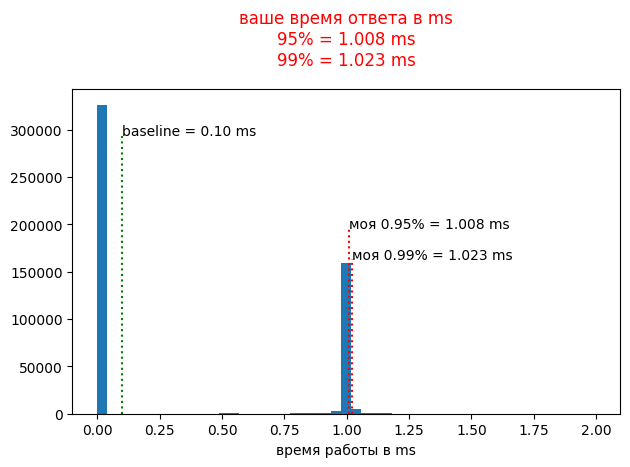

In [26]:
plt_vals = plt.hist(times, bins=np.linspace(np.quantile(times, 0.001), np.quantile(times, 0.999)))

plt.vlines(0.10, 0, plt_vals[0].max() * 0.9, color='green', linestyle=':')
plt.text(0.10, plt_vals[0].max() * 0.9, s='baseline = 0.10 ms', color='black', rotation=0)

plt.vlines(np.quantile(times, 0.95), 0, plt_vals[0].max() * 0.6, color='red', linestyle=':')
plt.vlines(np.quantile(times, 0.99), 0, plt_vals[0].max() * 0.5, color='red', linestyle=':')

plt.text(
    np.quantile(times, 0.95), plt_vals[0].max() * 0.6,
    s=f'моя 0.95% = {np.quantile(times, 0.95):0.3f} ms', color='black', rotation=0
)
plt.text(
    np.quantile(times, 0.99), plt_vals[0].max() * 0.5,
    s=f'моя 0.99% = {np.quantile(times, 0.99):0.3f} ms', color='black', rotation=0
)

plt.title(
    f'ваше время ответа в ms\n95% = {np.quantile(times, 0.95):0.3f} ms\n99% = {np.quantile(times, 0.99):0.3f} ms',
    y=1.05,
    color=(
        'green'
        if (round(np.quantile(times, 0.95), 3) <= 0.10) & (round(np.quantile(times, 0.99), 3) <= 0.10)
        else 'red'
    )
)

plt.xlabel('время работы в ms')
plt.tight_layout()
plt.show()

In [27]:
# Тут мы должны увидеть, что модель выдает предсказания быстрее ожидаемого
# Наше предсказание должно быть быстрее baseline в каждом случае

## тест 5: мониторинг времени (2)

In [28]:
row_input = {
    'client_id': -100,
    'регион': 'Plan_1',
    'использование': '<000',
    'сумма': 0,
    'частота_пополнения': 0.0,
    'доход': np.nan,
    'сегмент_arpu': np.nan,
    'частота': np.nan,
    'объем_данных': np.nan,
    'on_net': np.nan,
    'продукт_1': np.nan,
    'продукт_2': np.nan,
    'зона_1': np.nan,
    'зона_2': np.nan,
    'mrg_': True,
    'секретный_скор': 0.0,
    'pack': np.nan,
    'pack_freq': np.nan,
}

In [29]:
%%timeit
_ = get_score(row_input)

# Ожидаем скорость быстрее 110 µs (<110 µs)

317 μs ± 16.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## тест 6: мониторинг f1 score
- зеленый цвет названия графика означает, что тест пройден
- красный цвет названия графика означает, что тест не пройден

In [30]:
sum(preds)

121241

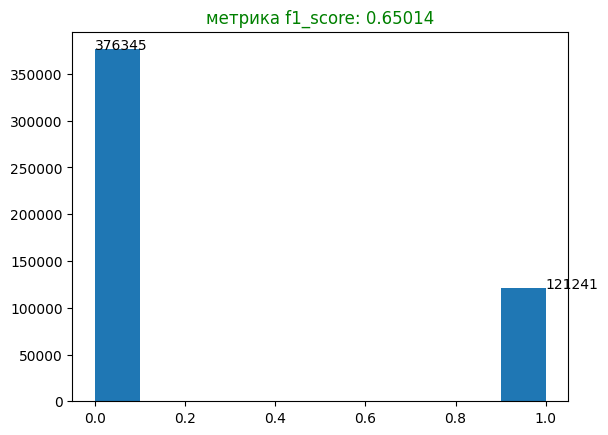

In [31]:
# Ожидаемая метрика >= 0.6450
plot_vals = plt.hist(preds)
plt.title(
    f"метрика f1_score: {f1_score(test['binary_target'], preds):0.5f}",
    color=('red' if f1_score(test['binary_target'], preds) < 0.6450 else 'green')
)

plt.text(0, plot_vals[0][0], s=f"{plot_vals[0][0]:0.0f}")
plt.text(1, plot_vals[0][-1], s=f"{plot_vals[0][-1]:0.0f}")

plt.show()

## тест 7: Code Style
- воспользуемся библиотекой для оценки качества кода https://github.com/nbQA-dev/nbQA?tab=readme-ov-file#-examples
- нужно установить актуальную версию pip install flake8
- нужно установить актуальную версию pip install -U nbqa
- в отдельной ячейке нужно выполнить команду: !nbqa flake8 ML_итоговая_шаблон.ipynb (см. эту команду ниже)
- поставьте вместо ML_итоговая_шаблон.ipynb ваше название ноутбука
- запрещается менять эту команду, за исключением названия ноутбука

In [32]:
! nbqa flake8 --extend-ignore=W291,E501 ml-final.ipynb & echo 'everything done'

'everything done'


In [33]:
os.system("nbqa flake8 --extend-ignore=W291,E501 ml-final.ipynb & echo 'everything done'")

0

In [34]:
# ячейка выше должна отпринтовать следующее
# everything done
# 0

# если помимо этого есть и другие строчки - это ошибки по pep8, их нужно исправлять
# например строчка teta_ML_итоговая_шаблон.ipynb:cell_27:1:1: F401 'scipy' imported but unused
# означает, что был бесполезный import scipy, который нигде не использовался

### Если все тесты пройдены успешно, вы можете претендовать на наивысшый балл (⌐■_■)

In [35]:
print('Ура!')

Ура!
